In [1171]:
# Modules de base
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd 

# Module relatif à Gurobi
from gurobipy import *

# Module csv
import csv

## Importation des données

In [1172]:
# Instance_file : str
Instance_file = "InstanceBordeauxV1.xlsx"

# Chargement des donnees
Employees = pd.read_excel(Instance_file, sheet_name= 'Employees')
Tasks = pd.read_excel(Instance_file, sheet_name= 'Tasks')
Employees_Unavailabilities = pd.read_excel(Instance_file, sheet_name= 'Employees Unavailabilities')
Tasks_Unavailabilities = pd.read_excel(Instance_file, sheet_name= 'Tasks Unavailabilities')

#print(Employees)
#print(Tasks)
print(Employees_Unavailabilities)

  EmployeeName   Latitude  Longitude    Start     End
0        Ambre  44.754683  -0.668761  12:00pm  1:00pm


## Création des dictionnaires de paramètres

Listes des dictionnaires de paramètres à créer:
- LevelEmployee[i] qui à un employé i lui associe son niveau de compétence
- BeginningEmployee[i] qui à un employé i lui associe son début de journée de travail
- EndEmployee[i] qui à un employé i lui associe sa fin de journée de travail
- LevelTask[j] qui à une tâche j lui associe son niveau de difficulté
- BeginningTask[j] qui à une tâche j lui aussi le début du créneau durant lequel on peut l'effectuer
- EndTask[j] qui à une tâche j lui aussi la fin du créneau durant lequel on peut l'effectuer
- DurationTask[j] qui à une tâche j lui associe sa durée
- TasksUnavailabilities[j]
- DistDict[i][j] dictionnaire contenant les distances entre toutes les tâches et les domiciles des employées
- TimeDict[i][j] dictionnaire contenant les temps de trajet associés
- Unavailability[l]: recense les indisponibilités sous forme (employe, debutindispo, duree)

In [1173]:
#Paramètres
N = len(Employees["EmployeeName"])
K = len(Tasks["TaskId"])
L = len(Employees_Unavailabilities["EmployeeName"])



LevelEmployee = dict()

for i in range (len(Employees["EmployeeName"])):
    a = Employees["EmployeeName"][i]
    b = Employees["Level"][i]
    LevelEmployee[i+1] = b

#print(LevelEmployee)

BeginningEmployee = dict()

for i in range (len(Employees["EmployeeName"])):
    a = Employees["EmployeeName"][i]
    b = Employees["WorkingStartTime"][i][:1]
    bg = b[:2]   #prend les deux premiers caractères
    bd = b[-3:]
    if bg[-1:] == ":":  #cas où l'heure n'a qu'un chiffre
        b = int(b[:1]) + int(bd[:2]) *100/60
        
    if bg[-1:] != ":":
        b = int(b[:2]) + int(bd[-2:]) *100/60

    if Employees["WorkingStartTime"][i][-2:] == 'am':
        BeginningEmployee[a] = b
    if Employees["WorkingStartTime"][i][2:] == "pm":
        BeginningEmployee[a] = b + 12

#print(BeginningEmployee)

EndEmployee = dict()

for i in range (len(Employees["EmployeeName"])):
    a = Employees["EmployeeName"][i]
    b = Employees["WorkingEndTime"][i][:1]
    bg = b[:2]   #prend les deux premiers caractères
    bd = b[-3:]
    if bg[-1:] == ":":  #cas où l'heure n'a qu'un chiffre
        b = int(b[:1]) + int(bd[:2]) *100/60
        
    if bg[-1:] != ":":
        b = int(b[:2]) + int(bd[-2:]) *100/60

    if Employees["WorkingEndTime"][i][-2:] == 'am':
        EndEmployee[a] = b
    if Employees["WorkingEndTime"][i][2:] == "pm":
        EndEmployee[a] = b + 12

#print(EndEmployee)

LevelTask = dict()

for i in range (len(Tasks["TaskId"])):
    a = i+1
    b = Tasks["Level"][i]
    LevelTask[a] = b

#print(LevelTask)

TasksUnavailabilities = dict()

for i in range (len(Tasks_Unavailabilities["TaskId"])):
    a = Tasks_Unavailabilities["TaskId"][i] 
    b = Tasks_Unavailabilities["Start"][i][:5]
    bg = b[:2]   #prend les deux premiers caractères
    bd = b[-3:]
    if bg[-1:] == ":":  #cas où l'heure n'a qu'un chiffre
        b = int(b[:1]) + int(bd[:2]) *100/60
        
    if bg[-1:] != ":":
        b = int(b[:2]) + int(bd[-2:]) *100/60
        
    c = Tasks_Unavailabilities["End"][i][:5]
    cg = c[:2]   #prend les deux premiers caractères
    cd = c[-3:]
    if cg[-1:] == ":":  #cas où l'heure n'a qu'un chiffre
        c = int(c[:1]) + int(cd[:2]) *100/60
        
    if cg[-1:] != ":":
        c = int(c[:2]) + int(cd[-2:]) *100/60

    if Tasks_Unavailabilities["Start"][i][-2:] == 'pm' and b!=12:
        b = b + 12
    if Tasks_Unavailabilities["End"][i][2:] == "pm" and c!=12:
        c = c + 12
    TasksUnavailabilities[a] = [b,c]

#print(TasksUnavailabilities)

Unavailability = dict()

for i in range (len(Employees_Unavailabilities["EmployeeName"])):
    for k in range (len(Employees["EmployeeName"])):
        if Employees_Unavailabilities["EmployeeName"][i] == Employees["EmployeeName"][k]:
            a = k + 1
    b = Employees_Unavailabilities["Start"][i][:5]
    bg = b[:2]   #prend les deux premiers caractères
    bd = b[-3:]
    if bg[-1:] == ":":  #cas où l'heure n'a qu'un chiffre
        b = int(b[:1]) + int(bd[:2]) *100/60
        
    if bg[-1:] != ":":
        b = int(b[:2]) + int(bd[-2:]) *100/60
        
    c = Employees_Unavailabilities["End"][i][:5]
    cg = c[:2]   #prend les deux premiers caractères
    cd = c[-3:]
    if cg[-1:] == ":":  #cas où l'heure n'a qu'un chiffre
        c = int(c[:1]) + int(cd[:2]) *100/60
        
    if cg[-1:] != ":":
        c = int(c[:2]) + int(cd[-2:]) *100/60
    if Employees_Unavailabilities["Start"][i][-2:] == 'pm'and b!=12:
        b = int(b) + 12
    if Employees_Unavailabilities["End"][i][2:] == "pm" and c!=12:
        c = int(c) + 12 - b
    Unavailability[i+1] = [a,b,c]

#print(Unavailability)


BeginningTask = dict()

for i in range(K+L+2*N): 
    if i < L:
        a = Employees_Unavailabilities["EmployeeName"][i]
        b = Employees_Unavailabilities["Start"][i][:5]
        c = Employees_Unavailabilities["Start"][i] 

    if i >= L and i < L+K:
        a = Tasks["TaskId"][i-L]
        b = Tasks["OpeningTime"][i-L][:5]
        c = Tasks["OpeningTime"][i-L]
    if i >= L+K and i < L+K+N:
        a = Employees["EmployeeName"][i-L-K]
        b = Employees["WorkingStartTime"][i-L-K][:5]
        c = Employees["WorkingStartTime"][i-L-K]
    if i >= L+K+N:
        a = Employees["EmployeeName"][i-L-K-N]
        b = Employees["WorkingEndTime"][i-L-K-N][:5]
        c = Employees["WorkingEndTime"][i-L-K-N]

    ### conversion sous format decimal 12:30 => 12,5
    bg = b[:2]   #prend les deux premiers caractères
    bd = b[-3:]
    if bg[-1:] == ":":  #cas où l'heure n'a qu'un chiffre
        b = int(b[:1]) + int(bd[:2]) *100/60
        
    if bg[-1:] != ":":
        b = int(b[:2]) + int(bd[-2:]) *100/60
        
    if c[-2:] == 'am':
        if bg != '12':
            #BeginningTask[a] = b
            BeginningTask[i+1] = b
        else:
            BeginningTask[i+1] = b - 12   
    if c[-2:] == "pm":
        if bg != '12':
            #BeginningTask[a] = b + 12
            BeginningTask[i+1] = b + 12
        else:
            BeginningTask[i+1] = b


#print(BeginningTask)


EndTask = dict()

for i in range (0,K+L+2*N): 
    if i < L:
        a = Employees_Unavailabilities["EmployeeName"][i]
        b = Employees_Unavailabilities["End"][i][:5]
        c = Employees_Unavailabilities["End"][i]
    if i >= L and i < L+K:
        a = Tasks["TaskId"][i-L]
        b = Tasks["ClosingTime"][i-L][:5]
        c = Tasks["ClosingTime"][i-L]
    if i >= L+K and i < L+K+N:
        a = Employees["EmployeeName"][i-L-K]
        b = Employees["WorkingStartTime"][i-L-K][:5]
        c = Employees["WorkingStartTime"][i-L-K]
    if i >= L+K+N:
        a = Employees["EmployeeName"][i-L-K-N]
        b = Employees["WorkingEndTime"][i-L-K-N][:5]
        c = Employees["WorkingEndTime"][i-L-K-N]
    bg = b[:2]   #prend les deux premiers caractères
    bd = b[-3:]
    
    if bg[-1:] == ":":  #cas où l'heure n'a qu'un chiffre
        b = int(b[:1]) + int(bd[:2]) *100/60
        
    if bg[-1:] != ":":
        b = int(b[:2]) + int(bd[-2:]) *100/60
        
    if c[-2:] == 'am':
        if bg != '12':
            #BeginningTask[a] = b
            EndTask[i+1] = b
        else:
            EndTask[i+1] = b - 12   
    if c[-2:] == "pm":
        if bg != '12':
            #EndTask[a] = b + 12
            EndTask[i+1] = b + 12
        else:
            EndTask[i+1] = b

#print(EndTask)


DurationTask = dict()
for i in range (L):
    a = i + 1
    b = Unavailability[i+1][2]
    DurationTask[a] = b
for i in range (K):
    a = L + i + 1
    b = Tasks["TaskDuration"][i] / 60
    DurationTask[a] = b

for i in range (N):
    a = L + K + i + 1
    b = 0
    DurationTask[a] = b
    DurationTask[a+N] = b

print(DurationTask)

Position = dict()   # contient les positions des tâches indispo

for i in range (L+K+2*N):
    if i < L:
        L_i = Employees_Unavailabilities["Longitude"][i]
        l_i = Employees_Unavailabilities["Latitude"][i]
    if i >= L and i < L+K:
        L_i = Tasks["Longitude"][i-L]
        l_i = Tasks["Latitude"][i-L]
    if i >= L+K and i < L+K+N:
        L_i = Employees["Longitude"][i-L-K]
        l_i = Employees["Latitude"][i-L-K]
    if i >= L+K+N :
        L_i = Employees["Longitude"][i-L-K-N]
        l_i = Employees["Latitude"][i-L-K-N]
    Position[i+1] = [L_i, l_i]

        


##Création du dictionnaire des distances
#DistDic: associe à (i,j) la distance entre les deux tâches

DistDict = dict()
R = 6371  #rayon de la Terre

for i in range (1,L+K+2*N+1):               ## ajout des distances entre tasks
    for k in range (1,L+K+2*N+1):
            L_i = Position[i][0]
            l_i = Position[i][1]
            L_k = Position[k][0]
            l_k = Position[k][1]
            A = np.sin((l_i-l_k)*np.pi/(2*180))**2
            B = (np.sin((L_i-L_k)*np.pi/(2*180))**2)*np.cos(l_i*np.pi/180)*np.cos(l_k*np.pi/180)
            d = 2*R*np.sqrt(A+B)
            DistDict[(i,k)] = d


#print(DistDict)

##Création dictionnaire des temps de trajet

# TimeDict : associe à un trajet (i,j) le temps de trajet en h


TimeDict = dict()

for element in DistDict.items():
    t = element[1] / 50
    TimeDict[element[0]] = t

print(TimeDict)


{1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0, 5: 1.0, 6: 1.0, 7: 1.0, 8: 1.0, 9: 1.0, 10: 1.25, 11: 1.0, 12: 0, 14: 0, 13: 0, 15: 0}
{(1, 1): 0.0, (1, 2): 0.7068321738920618, (1, 3): 0.48266735050330567, (1, 4): 0.8723917596527174, (1, 5): 1.145970289462423, (1, 6): 0.6443522169870193, (1, 7): 0.9968653693713762, (1, 8): 1.504648883887421, (1, 9): 0.6363339980999713, (1, 10): 1.2688136407746944, (1, 11): 0.7582880833272797, (1, 12): 0.9142734350423755, (1, 13): 1.018371332643951, (1, 14): 0.9142734350423755, (1, 15): 1.018371332643951, (2, 1): 0.7068321738920618, (2, 2): 0.0, (2, 3): 1.0217165126372043, (2, 4): 1.4614402548607615, (2, 5): 1.7287379164063463, (2, 6): 1.2170045168101324, (2, 7): 1.5802896694770947, (2, 8): 2.1298880486390215, (2, 9): 1.2926838792504105, (2, 10): 1.90418311153199, (2, 11): 1.3973216507616857, (2, 12): 1.541753427708023, (2, 13): 1.6347694715665246, (2, 14): 1.541753427708023, (2, 15): 1.6347694715665246, (3, 1): 0.48266735050330567, (3, 2): 1.0217165126372043, (3, 3):

## Modules

In [1174]:
# Modules de base
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.ticker import MultipleLocator, FormatStrFormatter

# Module relatif à Gurobi
from gurobipy import *

## Données

In [1175]:
# number_of_employees : int
N=len(Employees)

# number_of_tasks : int
K=len(Tasks)

# number_of_unavailabilities : int
L=len(Unavailability)



## Variables

In [1176]:
# -- Initialisation du modèle --
# m : Model
m = Model("ProjetST7")

# -- Ajout des variables  --
# X: dict[(int, int) : Var]
X = {(i,j) : m.addVar(vtype = GRB.BINARY, name = f'employeetask{i}_{j}') for i in range(1, N+1) for j in range(1,K+L+2*N+1)}

# T : dict[int : Var]
T = {(j) : m.addVar(vtype = GRB.CONTINUOUS, name=f'begintask_{j}') for j in range(1, K+L+2*N+1)}

# Y: dict[(int, int) : Var]
Y = {(i,j) : m.addVar(vtype = GRB.BINARY, name = f'successivetask{i}_{j}') for i in range(1, K+L+2*N+1) for j in range(1,K+L+2*N+1)}

## Contraintes

- Un employé pour une tâche

In [1177]:
# OneEmployeePerTaskConstrDict : dict[int : Constr]
OneEmployeePerTaskConstrDict = {j : m.addConstr(quicksum([X[(i, j)] for i in range(1, N + 1)]) == 1, name = f'one_employee_per_task{j}') for j in range(1, L+K+2*N + 1)}

- Niveau de l'employé suffisant pour la tâche

In [1178]:
# MinimumLevelConstrDict : dict[(int,int) : Constr]
MinimumLevelConstrDict = {(i,j) : m.addConstr(LevelTask[j]*X[(i,j+L)] <= LevelEmployee[i]  , name = f'level_{i}_{j}') for i in range(1, N + 1) for j in range(1,K+1) }

- Début et fin de chaque tâche

In [1179]:
# StartConstrDict : dict[(int,int) : Constr]
StartConstrDict = {j : m.addConstr(T[j] >= BeginningTask[j], name = f'start_{j}') for j in range(1,K+L+2*N+1) }
EndConstrDict = {j : m.addConstr(T[j]+DurationTask[j]<=EndTask[j], name = f'end_{j}') for j in range(1,K+L+2*N+1) }

- Délai entre 2 tâches successives

In [1180]:
M=10000
SuccessiveTasksGapConstrDict = {(i,j) : m.addConstr((T[j]-T[i]) - (Y[(i,j)]*(DurationTask[i]+TimeDict[(i,j)])+(1-Y[(i,j)])*(-M)) >= 0 , name = f'successivetaksgap_{i}_{j}') for i in range(1, K+L+2*N+1) for j in range(1, K+L+2*N+1) if i!=j }
#SuccessiveTasksGapConstrDict = {(i,j) : m.addConstr((T[j]-T[i]) - (Y[(i,j)]*(DurationTask[i]+TimeDict[(i,j)])+(1-Y[(i,j)])*(-M)) >= 0 , name = f'successivetaksgap_{i}_{j}') for i in range(1, K+L+2*N+1) for j in range(1,K+L+2*N+1) if (i,j) in DistDict.keys() }


- Une seule tâche succède à une autre

In [1181]:
#contrainte d'entrée/sortie
OneTaskAfterAnother1ConstrDict = {j : m.addConstr(quicksum(Y[(k,j)] for k in range(1,K+L+2*N+1)) == 1, name = f'OneTaskAfterAnother1_{j}') for j in range(K+L+N+1, K+L+2*N+1) if j!=k}
OneTaskAfterAnother2ConstrDict = {j : m.addConstr(quicksum(Y[(j,k)] for k in range(1,K+L+2*N+1)) == 1, name = f'OneTaskAfterAnother2_{j}') for j in range(K+L+1, K+L+N+1) if j!=k}

#contrainte de flot
OneTaskAfterAnother3ConstrDict = {j : m.addConstr(quicksum(Y[(j,k)] for k in range(1,K+L+2*N+1)) - quicksum(Y[(k,j)] for k in range(1,K+L+2*N+1)) == 0 , name = f'OneTaskAfterAnother3_{j}') for j in range(1,K+L+1) }
OneTaskAfterAnother4ConstrDict = {j : m.addConstr(quicksum(Y[(k,j)] for k in range(1,K+L+2*N+1)) == 1, name = f'OneTaskAfterAnother4_{j}') for j in range(L+1, K+L+1) }
OneTaskAfterAnother5ConstrDict = {j : m.addConstr(quicksum(Y[(j,k)] for k in range(1,K+L+2*N+1)) == 1, name = f'OneTaskAfterAnother5_{j}') for j in range(L+1, K+L+1) }
#ontrainte sur les indispos
OneTaskAfterAnother6ConstrDict = {j : m.addConstr(quicksum(Y[(k,j)] for k in range(1,K+L+2*N+1)) == 1, name = f'OneTaskAfterAnother6_{j}') for j in range(1, L+1) }
OneTaskAfterAnother7ConstrDict = {j : m.addConstr(quicksum(Y[(j,k)] for k in range(1,K+L+2*N+1)) == 1, name = f'OneTaskAfterAnother7_{j}') for j in range(1, L+1) }

TwoSuccessivesTasksCantBeTheSame = {j : m.addConstr(Y[(j,j)]==0) for j in range(1,K+L+2*N+1) }

- Si deux tâches sont successives il existe k tel que ces tâches sont effectuées par le même employé

In [1182]:
SuccessiveTasksOneEmployee1ConstrDict = {(i,j,k) : m.addConstr(1-Y[(i,j)]-(X[(k,i)]-X[(k,j)])>=0 , name = f'successivetaksoneemployee1_{i}_{j}_{k}') for i in range(1, K+L+1) for j in range(1, K+L+1) for k in range(1,N+1) }
SuccessiveTasksOneEmployee2ConstrDict = {(i,j,k) : m.addConstr(1-Y[(i,j)]+(X[(k,i)]-X[(k,j)])>=0 , name = f'successivetaksoneemployee2_{i}_{j}_{k}') for i in range(1, K+L+1) for j in range(1, K+L+1) for k in range(1,N+1) }
SuccessiveTasksOneEmployee3ConstrDict = {(i,j,k) : m.addConstr(1-Y[(i,j)]+(X[(k,i)]-X[(k,j)])>=0 , name = f'successivetaksoneemployee3_{i}_{j}_{k}') for i in range(K+L+1,K+L+2*N+1) for j in range(1,K+L+2*N+1) for k in range(1,N+1) }
SuccessiveTasksOneEmployee3ConstrDict = {(i,j,k) : m.addConstr(1-Y[(i,j)]-(X[(k,i)]-X[(k,j)])>=0 , name = f'successivetaksoneemployee3_{i}_{j}_{k}') for i in range(1,K+L+2*N+1) for j in range(K+L+1,K+L+2*N+1) for k in range(1,N+1) }
#idée pour empêcher qu'un employé qui ne fait aucune tâche ne fasse pas le chemin entre les deux
#SuccessiveTasksOneEmployee4ConstrDict = {(i,j,k) : m.addConstr( Y[(i,j)]-(X[(k,i)]+X[(k,j)])/2 <=0 , name = f'successivetaksoneemployee4_{i}_{j}_{k}') for i in range(1, L+1) for j in range(1,L+1) for k in range(1,N+1) }

- Contrainte d'attribution des indisponibilités et départ/retour au domicile aux bons employés

In [1183]:
UnavailabilityConstr = {i : m.addConstr( X[(Unavailability[i][0], i)] == 1 , name = f'unavailabilityemployee_{i}') for i in range(1,L+1) }
HomeDepartureConstr = {i : m.addConstr( X[(i, L+K+i)] == 1 , name = f'homedepartureemployee_{i}') for i in range(1,N+1) }
HomeReturnConstr = {i : m.addConstr( X[(i, L+K+N+i)] == 1 , name = f'homereturnemployee_{i}') for i in range(1,N+1) }

- Fixer heure debut indispo

In [1184]:
UnavailabilityTimeConstr = {i : m.addConstr( T[i] - BeginningTask[i] == 0 , name = f'unavailabilitytimeemployee_{i}') for i in range(1,L+1)}

## Fonction Objectif

In [1185]:
# -- Ajout de la fonction objectif --
#m.setObjective(quicksum(Y[(i,j)]*TimeDict[(i,j)] for i in range (1,K+L+2*N+1) for j in range (1,K+L+2*N+1) if (i,j)  in DistDict.keys() ), GRB.MINIMIZE)
m.setObjective(quicksum(Y[(i,j)]*TimeDict[(i,j)] for (i,j)  in DistDict.keys() ), GRB.MINIMIZE)


In [1186]:
# -- Choix d'un paramétrage d'affichage minimaliste --
m.params.outputflag = 0 # mode muet

# -- Mise à jour du modèle  --
m.update()

print(m.status)
# -- Résolution --
m.optimize()



1


In [1187]:
print(m.ObjVal)

5.25577439825619


In [1188]:
#Extraction des sorties

routeindex = dict() #dictionnaire contenant les listes ordonnées des indices des taches réalisées associé à chque employé i (i étant la valeur de la clé)
routes = dict()   #contient les points de la route de chaque employé sous forme de liste de tuple (latitude,longitude)


X0 = dict()
Y0 = dict()
T0 = dict()

for i in range (1,N+1):
    for j in range(1, L + K + 2*N + 1):
        X0[(i,j)] = m.getVarByName(f'employeetask{i}_{j}').x


for j in range(1, L + K + 2*N + 1):
    T0[(j)] = m.getVarByName(f'begintask_{j}').x

for i in range (1, L + K + 2*N +1):
    for j in range(1, L + K + 2*N + 1):
        Y0[(i,j)] = m.getVarByName(f'successivetask{i}_{j}').x

print("X0")
print(X0)
print("T0")
print(T0)
print("Y0")
print(Y0)

for i in range (1, N+1):        #on va pour chaque employé retracer son trajet grâce à Y i_j
    a = Employees["EmployeeName"][i-1]
    routeIndiv = []
    m = K+L+i+1
    routeIndiv.append(m)
    while m!= K+L+N+i:
        for j in range (1, L+K+2*N+1):
            if  Y0[(m,j)] == 1 :   #à adapter pour que ça fonctionne avec Y variable du pb
                m = j
                routeIndiv.append(m)
        break
    routeindex[a] = routeIndiv   


for k in routeindex.keys():
    routes[k] = [(Position[i][0],Position[i][1]) for i in routeindex[k]]   #ensemble des points (longitude, Latitude) organisés en listes de trajet par employé  

#print(route)


#def plotRoute(route):
 #   xs = [task[0] for task in route] + [task[0][0]]
  #  ys = [task[1] for task in route] + [task[0][1]]
   # plt.plot(xs, ys, 'o-')


#for key in routes.keys():
#    plotRoute(routes[key])

#plt.ylabel('x')
#plt.xlabel('y')
#plt.show()


X0
{(1, 1): 0.0, (1, 2): -0.0, (1, 3): -0.0, (1, 4): 1.0, (1, 5): 1.0, (1, 6): 1.0, (1, 7): 1.0, (1, 8): 1.0, (1, 9): -0.0, (1, 10): 1.0, (1, 11): -0.0, (1, 12): 1.0, (1, 13): 0.0, (1, 14): 1.0, (1, 15): 0.0, (2, 1): 1.0, (2, 2): 1.0, (2, 3): 1.0, (2, 4): 0.0, (2, 5): 0.0, (2, 6): 0.0, (2, 7): 0.0, (2, 8): 0.0, (2, 9): 1.0, (2, 10): 0.0, (2, 11): 1.0, (2, 12): 0.0, (2, 13): 1.0, (2, 14): 0.0, (2, 15): 1.0}
T0
{1: 12.0, 2: 13.706832173891598, 3: 15.728548686529386, 4: 14.275034268181107, 5: 12.0, 6: 15.519626629375102, 7: 13.150503645807476, 8: 9.487787801594095, 9: 9.392801007676082, 10: 8.0, 11: 8.263844681785478, 12: 7.0, 13: 8.0, 14: 17.0, 15: 18.0}
Y0
{(1, 1): 0.0, (1, 2): 1.0, (1, 3): -0.0, (1, 4): 0.0, (1, 5): -0.0, (1, 6): 0.0, (1, 7): 0.0, (1, 8): -0.0, (1, 9): -0.0, (1, 10): 0.0, (1, 11): -0.0, (1, 12): 0.0, (1, 13): 0.0, (1, 14): 0.0, (1, 15): 0.0, (2, 1): -0.0, (2, 2): 0.0, (2, 3): 1.0, (2, 4): -0.0, (2, 5): -0.0, (2, 6): -0.0, (2, 7): -0.0, (2, 8): -0.0, (2, 9): -0.0, (2, 1

In [1189]:
SolDict={'taskId' : [],'performed' : [] ,'employee_name' : [] ,'start_time' : []}  #forme de solution pour le rendu

for i in range(1,len(Tasks)+L+1):
    if i <= L:
        SolDict['taskId'].append("Indispo{}".format(i))
    if i >= L+1:
        SolDict['taskId'].append(Tasks['TaskId'][i-L-1])
    SolDict['performed'].append(1) #on fait toutes les tâches 
    for k in range(len(Employees)):
        if X0[(k+1,i+len(Employees_Unavailabilities))]==1:
            SolDict['employee_name'].append(Employees['EmployeeName'][k])
    SolDict['start_time'].append(int(T0[i+len(Employees_Unavailabilities)]*60))
    
    
#print(Tasks['TaskId'][0])
#print(Employees['EmployeeName'][0])
#print(SolDict)


EnsembleRoutesIndex = dict()  #ensemble des routes des employés représentées par des listes des indices des tâches dans l'ordre
EnsembleRoutesLoc = dict()


for i in range(len(SolDict['employee_name'])):
    if SolDict['employee_name'][i] not in EnsembleRoutesIndex.keys():        #on va pour chaque employé retracer son trajet grâce à Y i_j
        a = SolDict['employee_name'][i]
        route = []
        for j in range (len(SolDict['employee_name'])):          #on construit la liste des tâches de l'employé i
            if SolDict['employee_name'][j] == a:
                route.append(j+1)
        for k in range (len(route)): # on la classe selon les durée de début des taches pour obtenir la route
            for l in range (len(route)):
                if SolDict['start_time'][k] > SolDict['start_time'][l]: # on aurait pu faire mieux en terme de complexité
                    route[k], route[l] = route[l], route[k] 
        EnsembleRoutesIndex[SolDict['employee_name'][i]] = route
    
#print(EnsembleRoutesIndex)    
 

for k in EnsembleRoutesIndex.keys():
    EnsembleRoutesLoc[k] = [(Position[i][0],Position[i][1]) for i in EnsembleRoutesIndex[k]]   #ensemble des points (longitude, Latitude) organisés en listes de trajet par employé  

#print(EnsembleRoutesLoc)

In [1190]:
#On asssocie des couleurs aux employés pour faire la visualisation


dict_T={ i : {'Task' : 0,'Start_to_End' : 0 ,'Start' : 0, 'Color' : 0 } for i in range(1,len(Tasks)+1)}

Colors=['#E64646','#E69646','#34D05C','#34D0C3','#3475D0' ]


for i in range(1,len(Tasks)+1):
    dict_T[i]['Task']=Tasks['TaskId'][i-1]
    for k in range(len(Employees)):
        if X0[(k+1,i+len(Employees_Unavailabilities))]==1:
            dict_T[i]['Color']=Colors[k]
    dict_T[i]['Start']=int(T0[i+len(Employees_Unavailabilities)+1]*60)
    dict_T[i]['Start_to_End']= DurationTask[i]*60
    
print(dict_T)

{1: {'Task': 'T1', 'Start_to_End': 60.0, 'Start': 943, 'Color': '#E69646'}, 2: {'Task': 'T2', 'Start_to_End': 60.0, 'Start': 856, 'Color': '#E69646'}, 3: {'Task': 'T3', 'Start_to_End': 60.0, 'Start': 720, 'Color': '#E64646'}, 4: {'Task': 'T4', 'Start_to_End': 60.0, 'Start': 931, 'Color': '#E64646'}, 5: {'Task': 'T5', 'Start_to_End': 60.0, 'Start': 789, 'Color': '#E64646'}, 6: {'Task': 'T6', 'Start_to_End': 60.0, 'Start': 569, 'Color': '#E64646'}, 7: {'Task': 'T7', 'Start_to_End': 60.0, 'Start': 563, 'Color': '#E64646'}, 8: {'Task': 'T8', 'Start_to_End': 60.0, 'Start': 480, 'Color': '#E69646'}, 9: {'Task': 'T9', 'Start_to_End': 60.0, 'Start': 495, 'Color': '#E64646'}, 10: {'Task': 'T10', 'Start_to_End': 75.0, 'Start': 420, 'Color': '#E69646'}}


In [1191]:
import plotly.graph_objs as go
import plotly.express as px

In [1192]:
# Création d'une figure
fig = go.Figure()
# Ajout de marqueurs sur la carte
Points = dict()
for k in Position.keys(): #on parcourts

    lat, lon  = Position[k][1], Position[k][0]

    if k < L+1:
        text = "indispo{}".format(k)
    if k > L+K-1 and k <= L+K+N:
        text = "domicile{}".format(k-L-K+1)
    if k > L+K+N:
        text = "domicile{}".format(k-L-K-N)
    else:
        text = "T{}".format(k-L)

    for j in range (len(Employees["EmployeeName"])): #on va retrouver l'employé correspondnat à la tâche pour lui attribuer une couleur
        if k in EnsembleRoutesIndex[Employees["EmployeeName"][j]]:
            a = j + 1
    Points[text] = dict()
    Points[text]["lat"] = lat
    Points[text]["lon"] = lon
    Points[text]["color"] = dict_T[a]['Color']



for nom, coordonnees in Points.items():
    print(coordonnees)
    fig.add_trace(go.Scattermapbox(
    mode="markers",
    lon=[coordonnees["lon"]],
    lat=[coordonnees["lat"]],
    marker=dict(
        size=10,
        color=coordonnees["color"],
    ),
    text=[nom],
))     

#print(Points)

# Ajout d'un segment sur la carte    k Employee["EmployeeName"][k]
for k in range (len(EnsembleRoutesLoc.keys())) :
    a = Employees["EmployeeName"][k]
    for i in range (len(EnsembleRoutesLoc[a])-1):
        fig.add_trace(go.Scattermapbox(
    mode="lines",
    lon=[EnsembleRoutesLoc[a][i][0], EnsembleRoutesLoc[a][i+1][0]],
    lat=[EnsembleRoutesLoc[a][i][1], EnsembleRoutesLoc[a][i+1][1]],
    line=dict(width=2, color=dict_T[k+1]['Color']),
))
    fig.add_trace(go.Scattermapbox(
    mode="lines",
    lon=[EnsembleRoutesLoc[a][len(EnsembleRoutesLoc[a])-1][0], EnsembleRoutesLoc[a][0][0]],
    lat=[EnsembleRoutesLoc[a][len(EnsembleRoutesLoc[a])-1][1], EnsembleRoutesLoc[a][0][1]],
    line=dict(width=2, color=dict_T[k+1]['Color']),
))


# Configuration de la carte
fig.update_layout(
    mapbox=dict(
        style="open-street-map",
        center=go.layout.mapbox.Center(lon=-0.7, lat=0.3),
        zoom=7,
    ),
)

# Affichage de la carte
fig.show()

{'lat': 44.7546825494, 'lon': -0.6687606009488057, 'color': '#E69646'}
{'lat': 44.55654938342008, 'lon': -0.3193922422375719, 'color': '#E69646'}
{'lat': 44.96750095217799, 'lon': -0.6086852638150881, 'color': '#E69646'}
{'lat': 45.14421541464031, 'lon': -0.7342570469020379, 'color': '#E69646'}
{'lat': 45.264808304867096, 'lon': -0.7717887212411139, 'color': '#E69646'}
{'lat': 45.044422793402624, 'lon': -0.6687606009488057, 'color': '#E69646'}
{'lat': 45.19957452440505, 'lon': -0.7462077931750715, 'color': '#E69646'}
{'lat': 45.397697776585, 'lon': -0.9668192708194538, 'color': '#E69646'}
{'lat': 45.02347908679639, 'lon': -0.8072126299796225, 'color': '#E69646'}
{'lat': 45.29291368453335, 'lon': -0.9365361007032236, 'color': '#E69646'}
{'lat': 45.08146166752168, 'lon': -0.8062453230620741, 'color': '#E69646'}
{'lat': 45.15121765523164, 'lon': -0.822092647754919, 'color': '#E69646'}
{'lat': 45.19957452440505, 'lon': -0.822092647754919, 'color': '#E69646'}
{'lat': 45.15121765523164, 'lon

In [1193]:
# Modules de base
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd 

# Module relatif à Gurobi
from gurobipy import *

# Module csv
import csv

In [1194]:
# Instance_file : str
Instance_file = "InstanceGuineaGolfV1.xlsx"

# Chargement des donnees
Employees = pd.read_excel(Instance_file, sheet_name= 'Employees')
Tasks = pd.read_excel(Instance_file, sheet_name= 'Tasks')
Employees_Unavailabilities = pd.read_excel(Instance_file, sheet_name= 'Employees Unavailabilities')
Tasks_Unavailabilities = pd.read_excel(Instance_file, sheet_name= 'Tasks Unavailabilities')

#print(Employees)
#print(Tasks)
print(Employees_Unavailabilities)

# Chargement des donnees
Employees = pd.read_excel(Instance_file, sheet_name= 'Employees')
Tasks = pd.read_excel(Instance_file, sheet_name= 'Tasks')
Employees_Unavailabilities = pd.read_excel(Instance_file, sheet_name= 'Employees Unavailabilities')
Tasks_Unavailabilities = pd.read_excel(Instance_file, sheet_name= 'Tasks Unavailabilities')

print(Employees)
#print(Tasks)

Empty DataFrame
Columns: [EmployeeName, Latitude, Longitude, Start, End]
Index: []
  EmployeeName  Latitude  Longitude     Skill  Level WorkingStartTime  \
0          Tom  0.303747   0.815913  Plumbing      1           8:00am   

  WorkingEndTime  
0         6:00pm  


In [1195]:
SolDict={'taskId' : [],'performed' : [] ,'employee_name' : [] ,'start_time' : []}

for i in range(len(Tasks)):
    SolDict['taskId'].append(Tasks['TaskId'][i])
    SolDict['performed'].append(1) #on fait toutes les tâches 
    for k in range(len(Employees)):
        if X0[(k+1,i+len(Employees_Unavailabilities)+1)]==1:
            SolDict['employee_name'].append(Employees['EmployeeName'][k])
    SolDict['start_time'].append(int(T0[i+len(Employees_Unavailabilities)+1]*60))
    
    
print(Tasks['TaskId'][0])
print(Employees['EmployeeName'][0])
print(SolDict)
#len(Employees_Unavailabilities)

T1
Tom
{'taskId': ['T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7', 'T8', 'T9'], 'performed': [1, 1, 1, 1, 1, 1, 1, 1, 1], 'employee_name': ['Tom', 'Tom', 'Tom', 'Tom', 'Tom'], 'start_time': [720, 822, 943, 856, 720, 931, 789, 569, 563]}


In [1196]:
print(SolDict.keys())
for i in range(len(SolDict['taskId'])):
    print(SolDict['taskId'][i],';',SolDict['performed'][i],';',SolDict['employee_name'][i],';',SolDict['start_time'][i],';')

dict_keys(['taskId', 'performed', 'employee_name', 'start_time'])
T1 ; 1 ; Tom ; 720 ;
T2 ; 1 ; Tom ; 822 ;
T3 ; 1 ; Tom ; 943 ;
T4 ; 1 ; Tom ; 856 ;
T5 ; 1 ; Tom ; 720 ;


IndexError: list index out of range

In [1197]:
taskId;performed;employee_name;start_time;
T1;1;Tom;498;
T2;1;Tom;586;
T3;1;Tom;986;
T4;1;Tom;938;
T5;1;Tom;627;
T6;1;Tom;688;
T7;1;Tom;733;
T8;1;Tom;1034;
T9;1;Tom;836;

NameError: name 'taskId' is not defined

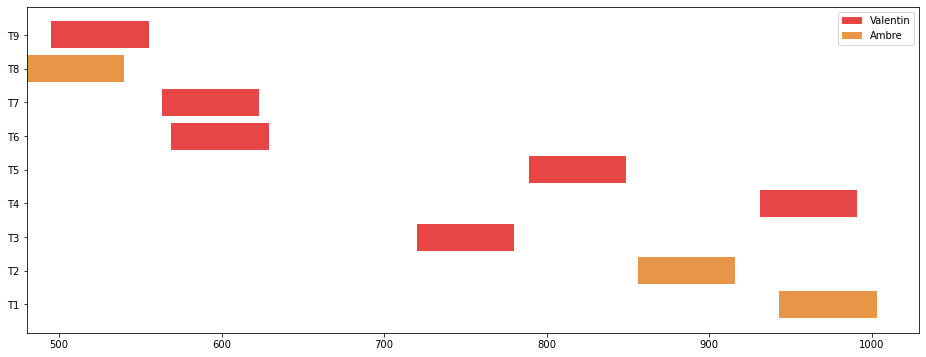

In [1198]:
import plotly.express as px
import pandas as pd

df = pd.DataFrame([
    dict_T[i] for i in range(1,len(Tasks)+1)
])

from matplotlib.patches import Patch
fig, ax = plt.subplots(1, figsize=(16,6))
ax.barh(df.Task, df.Start_to_End, left=df.Start, color=df.Color)
##### LEGENDS #####
c_dict = {'Valentin':'#E64646' , 'Ambre':'#E69646' }
legend_elements = [Patch(facecolor=c_dict[i], label=i)  for i in c_dict]
plt.legend(handles=legend_elements)

plt.show()